<a href="https://colab.research.google.com/github/Nithiya30/applied-ai-lab5/blob/main/aai_6th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip -q install scikit-learn

# ---- 1) Imports ----
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)

# =========================
# 2) Upload CSV (recommended)
# =========================
from google.colab import files
uploaded = files.upload()  # Upload: bank-additional.csv
csv_name = list(uploaded.keys())[0]
print("✅ Uploaded:", csv_name)


Saving bank-additional.csv to bank-additional (1).csv
✅ Uploaded: bank-additional (1).csv


✅ Loaded shape: (4119, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


✅ Features: (4119, 53) | Labels: (4119,)
Train: (2883, 53) Valid: (618, 53) Test: (618, 53)
BatchGD time: 6.51 sec | best val loss: 0.4781
SGD time: 48.44 sec | best val loss: 0.1767
MiniBatch time: 9.88 sec | best val loss: 0.1786
Momentum time: 2.5 sec | best val loss: 0.1776
Nesterov time: 2.33 sec | best val loss: 0.1775


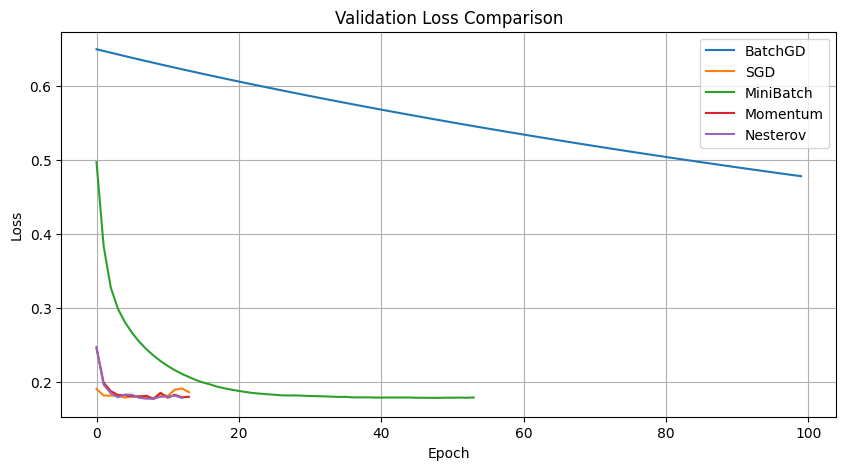

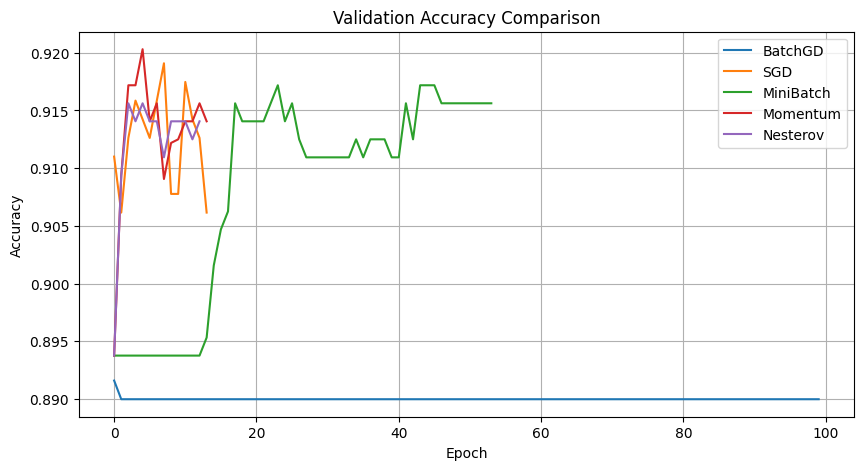


===== TEST RESULTS (Nesterov) =====
Test Accuracy: 0.9061488673139159
Precision: 0.6046511627906976
Recall: 0.3880597014925373
F1 Score: 0.4727272727272727
Confusion Matrix:
 [[534  17]
 [ 41  26]]


In [14]:
data = pd.read_csv(csv_name, sep=";")
print("✅ Loaded shape:", data.shape)
display(data.head())

cat_cols = data.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("y")  # target

num_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_part = encoder.fit_transform(data[cat_cols])

scaler = StandardScaler()
scaled_part = scaler.fit_transform(data[num_cols])

features = np.concatenate([scaled_part, encoded_part], axis=1)
labels = (data["y"] == "yes").astype(int).values

print("✅ Features:", features.shape, "| Labels:", labels.shape)

# =========================
# 5) Train/Val/Test split
# =========================
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

# =========================
# 6) Torch datasets
# =========================
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))

val_ds   = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                         torch.tensor(y_valid, dtype=torch.float32))

test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                         torch.tensor(y_test, dtype=torch.float32))

# =========================
# 7) Model
# =========================
class BankClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # logits (no sigmoid)
        )

    def forward(self, x):
        return self.model(x)

# =========================
# 8) Optimizers (as per your original)
# =========================
def get_optimizer(name, parameters, lr=0.01, momentum=0.9):
    if name == "Momentum":
        return optim.SGD(parameters, lr=lr, momentum=momentum)
    elif name == "Nesterov":
        return optim.SGD(parameters, lr=lr, momentum=momentum, nesterov=True)
    else:  # BatchGD, SGD, MiniBatch
        return optim.SGD(parameters, lr=lr)

# =========================
# 9) Metric
# =========================
def compute_accuracy(logits, targets):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int().cpu().numpy()
    return accuracy_score(targets.cpu().numpy(), preds)

# =========================
# 10) Training function (FIXED logits shape using .view(-1))
# =========================
def run_training(opt_name, lr=0.01, momentum=0.9, epochs=100, patience=5):
    net = BankClassifier(X_train.shape[1])
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = get_optimizer(opt_name, net.parameters(), lr=lr, momentum=momentum)

    # batch size selection
    if opt_name == "BatchGD":
        batch = len(train_ds)
    elif opt_name == "SGD":
        batch = 1
    else:  # MiniBatch, Momentum, Nesterov
        batch = 32

    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch, shuffle=False)

    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_loss = float("inf")
    early_stop_counter = 0

    start = time.time()

    for epoch in range(epochs):
        # ---- Train ----
        net.train()
        total_train_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = net(xb).view(-1)          # ✅ FIX (always shape [batch])
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # ---- Validate ----
        net.eval()
        val_loss_total = 0.0
        val_acc_list = []

        with torch.no_grad():
            for xb, yb in val_loader:
                logits = net(xb).view(-1)      # ✅ FIX
                loss = loss_fn(logits, yb)
                val_loss_total += loss.item()
                val_acc_list.append(compute_accuracy(logits, yb))

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss   = val_loss_total / len(val_loader)
        avg_val_acc    = float(np.mean(val_acc_list))

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(avg_val_acc)

        # early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    duration = time.time() - start
    return net, history, duration

# =========================
# 11) Run experiments
# =========================
optimizer_names = ["BatchGD", "SGD", "MiniBatch", "Momentum", "Nesterov"]
experiment_results = {}

for opt in optimizer_names:
    model, hist, train_time = run_training(opt, lr=0.01, momentum=0.9)
    experiment_results[opt] = (model, hist, train_time)
    print(opt, "time:", round(train_time, 2), "sec | best val loss:", round(min(hist["val_loss"]), 4))

# =========================
# 12) Plot Validation Loss
# =========================
plt.figure(figsize=(10, 5))
for name in experiment_results:
    plt.plot(experiment_results[name][1]["val_loss"], label=name)
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 13) Plot Validation Accuracy
# =========================
plt.figure(figsize=(10, 5))
for name in experiment_results:
    plt.plot(experiment_results[name][1]["val_acc"], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 14) Test Evaluation (Best = Nesterov) - FIXED
# =========================
best_net = experiment_results["Nesterov"][0]
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

all_preds, all_targets = [], []

best_net.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = best_net(xb).view(-1)  # ✅ FIX
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.cpu().numpy())

print("\n===== TEST RESULTS (Nesterov) =====")
print("Test Accuracy:", accuracy_score(all_targets, all_preds))
print("Precision:", precision_score(all_targets, all_preds))
print("Recall:", recall_score(all_targets, all_preds))
print("F1 Score:", f1_score(all_targets, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))
